# Exploratory Data Analysis

We will be using embedding representation of the sentence using BERT embeddings.

# BERT as a service

We will be running the full training dataset's sentences through [BERT](https://github.com/hanxiao/bert-as-service).

In [ ]:
# Install the necessary package

! pip install bert-serving-server  # server
! pip install bert-serving-client  # client, independent of `bert-serving-server`

Run BERT server elsewhere:

```
MODEL_DIR=/home/jovyan/work/bert/cased_L-12_H-768_A-12
bert-serving-start -model_dir $MODEL_DIR -num_worker=2 -max_seq_len 512 -max_batch_size 128
```

In [77]:
import os
os.chdir("/home/jovyan/work/data")

import numpy as np

import re
import pandas as pd

from tqdm import tqdm
from bert_serving.client import BertClient

import pickle as pkl

from tensorflow.keras.utils import to_categorical

import rpy2
%load_ext rpy2.ipython

In [ ]:
bc = BertClient()

Lets read the full training dataset downloaded from KAGGLE

In [3]:
df = pd.read_csv("train.csv")

In [23]:
def minimal_processing(sentences):
    return (sentences
                 .apply(lambda sentence:re.sub("[^\w]"," ",sentence))
                 .apply(lambda sentence: np.NaN if re.match('^\s+$', sentence) else sentence))

In [24]:
df["processed_text"] = minimal_processing(df.comment_text)
df = df[~df["processed_text"].isnull()]

In [46]:
sorted(df.columns.tolist())

['article_id',
 'asian',
 'atheist',
 'bisexual',
 'black',
 'buddhist',
 'christian',
 'comment_text',
 'created_date',
 'disagree',
 'female',
 'funny',
 'heterosexual',
 'hindu',
 'homosexual_gay_or_lesbian',
 'id',
 'identity_annotator_count',
 'identity_attack',
 'insult',
 'intellectual_or_learning_disability',
 'jewish',
 'latino',
 'likes',
 'male',
 'muslim',
 'obscene',
 'other_disability',
 'other_gender',
 'other_race_or_ethnicity',
 'other_religion',
 'other_sexual_orientation',
 'parent_id',
 'physical_disability',
 'processed_text',
 'psychiatric_or_mental_illness',
 'publication_id',
 'rating',
 'sad',
 'severe_toxicity',
 'sexual_explicit',
 'target',
 'threat',
 'toxicity_annotator_count',
 'transgender',
 'white',
 'wow']

In [54]:
y = np.where(df['target'] >= 0.5, True, False) * 1
y_binary = to_categorical(y)

print("{:.2f}%".format(int(y_binary[:, 0].sum()) / int(y_binary.shape[0])))

In [80]:
ys = np.array(df.target.tolist())

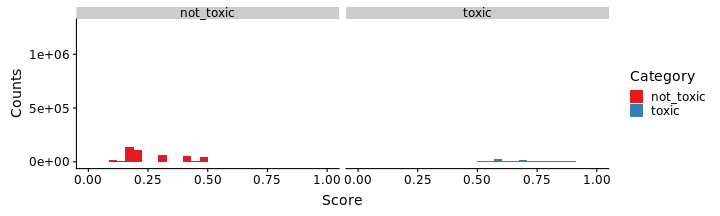

In [126]:
%%R -i ys -u in -w 10 -h 3

library(ggplot2)
library(tidyverse)
library(cowplot)
library(magrittr)

df = data.frame(target = ys) %>% mutate(class = factor(ifelse(target > 0.5, "toxic", "not_toxic")))


df %>% ggplot(aes(target, fill=class, group=class)) + 
    geom_histogram() + 
    facet_wrap(~class, ncol=2) +
    xlim(c(0, 1)) +
    labs(x="Score", y="Counts") +
    scale_fill_brewer("Category", palette="Set1")

In [42]:
df.to_csv("trained_processed.csv.gz", compression="gzip")

In [ ]:
embeddings = bc.encode(df.processed_text)

In [17]:
# pickle 4 lets you overcome the hard 4 Gb limit

pkl.dump(embeddings, open("embeddings.pkl","wb"), protocol=4)

In [127]:
df.shape[0] == embeddings.shape[0]

True

## Classification 

\begin{equation}
X=
\begin{cases}
    toxic, & \text{if}\ target > 0.5 \\
    neutral, & \text{otherwise}
\end{cases}
\end{equation}